# Semantic Segmentation of Colon Cancer Primaries¶

This is a demonstration of our deep learning pipeline to predict segmentation masks of colon cancer primaries in CT images.

We built our program so that it can easily be run from the command line. In this demonstration we will nevertheless import our functions and create and created an `Args()` class that can be used to specify the settings usually passed by the command line prompt. How to run our program from the command line is shown in the README.md file.

## Convert NIfTI to Numpy

To train our model and to predict segmentation masks we use axial 2D slices of the CT images, however the original data is provided in 3D NifTI files. We defined the `convert_to_npy()` function to convert 3D NifTI image files to 2D numpy files and save them. In this function we additionally create a JSON file that indexes every single slice. In this index we provide information of whether each slice containes tissue labled as cancer.

In the JSON file we assign each slice to the training or test subsets by calling `create_data_subsets()`. Here, the split ratio and whether to create a split based on individual slices or examples (patients) should be created. For our models we split on individual slices and ensured that the ratio between cancer and non-cancer slices is equal in test and training subset.

Both functions (`convert_to_npy()` and `create_data_subsets()`) are in `dataset.py`.


In [1]:
from dataset import convert_to_npy, create_data_subsets, dir_path
import os

os.makedirs('./data/', exist_ok=True)

In [2]:
class Args():
    datapath = dir_path('./Task10_Colon')
    path = dir_path('./data/')
    split_on = "slices"
    split = 0.1
    
args = Args()

In [3]:
convert_to_npy(args)
create_data_subsets(args)

Successfully created the directory ./data/npy_images/ 
Successfully created the directory ./data/npy_labels/ 
Saved slices of image 001
Saved slices of image 005
Saved slices of image 006
Saved slices of image 007
Saved slices of image 008
Saved slices of image 009
Saved slices of image 011
Saved slices of image 012
Saved slices of image 015
Saved slices of image 022
Saved slices of image 024
Saved slices of image 025
Saved slices of image 026
Saved slices of image 027
Saved slices of image 028
Saved slices of image 029
Saved slices of image 030
Saved slices of image 031
Saved slices of image 032
Saved slices of image 033
Saved slices of image 036
Saved slices of image 038
Saved slices of image 039
Saved slices of image 040
Saved slices of image 041
Saved slices of image 042
Saved slices of image 045
Saved slices of image 046
Saved slices of image 050
Saved slices of image 051
Saved slices of image 053
Saved slices of image 054
Saved slices of image 059
Saved slices of image 061
Saved 

## Dataset and Data Loader

### Dataset

We created a custom dataset class *ColonDataset*. It uses JSON file created by the `create_data_subsets()` function to load the image files assigned to the test or training subsets. The `ColonDataset()` class is defined in `data_loading.py`.

When instantiating the `ColonDataset()` class a sampling method can be set. Otherwise, it returns the original dataset.

The three custom sampling methods are *undersample*, *oversample* and *only_tumor*. The sampling methods are defined as `get_undersample_files()`, `get_oversample_files()`, `get_only_tumor_files()`, and `get_original_dataset()` in `data_loading.py`.

If the dataset is used for training, the images are augmented by several transformations: resize, random crop, horizontal flipping, vertical flipping, and normalization. Data used in model testing is only resized and normalized.

After instantiating `ColonDataset()` the dataset is split into training and validation set. This logic is implemented in the `load_datasets()` function. The `load_datasets()` function is in `train.py`.

**2) Data Loader**

We use the DataLoader function from **pytorch** (torch.utils.data.DataLoader) library. In the `load_dataloader()` function, two dataloaders (training and validation set) are created and saved in a dictionary as 'train' and 'val'. This dictionary is used in the training loop later.

In [4]:
from train import load_datasets, load_dataloader

In [5]:
class Args():
    split_ratio = 0.9
    train_batch = 12
    valid_batch = 12
    trainimages = "./data/npy_images"
    trainlabels = "./data/npy_labels"
    jsonfile = "./data/data_index_subsets.json"
    transform = True
    dataset_type = "only_tumor"
    image_size = 256
    workers = 4

args = Args()

In [6]:
train, valid = load_datasets(args)
train_dataloader = load_dataloader(args, train, valid)

## Visualizing Images

Here we plot several CT images from the first batch of train_dataloader. These images are automatically transformed by the transformations described above.

In [7]:
import matplotlib.pyplot as plt
from utils import gray2rgb, outline

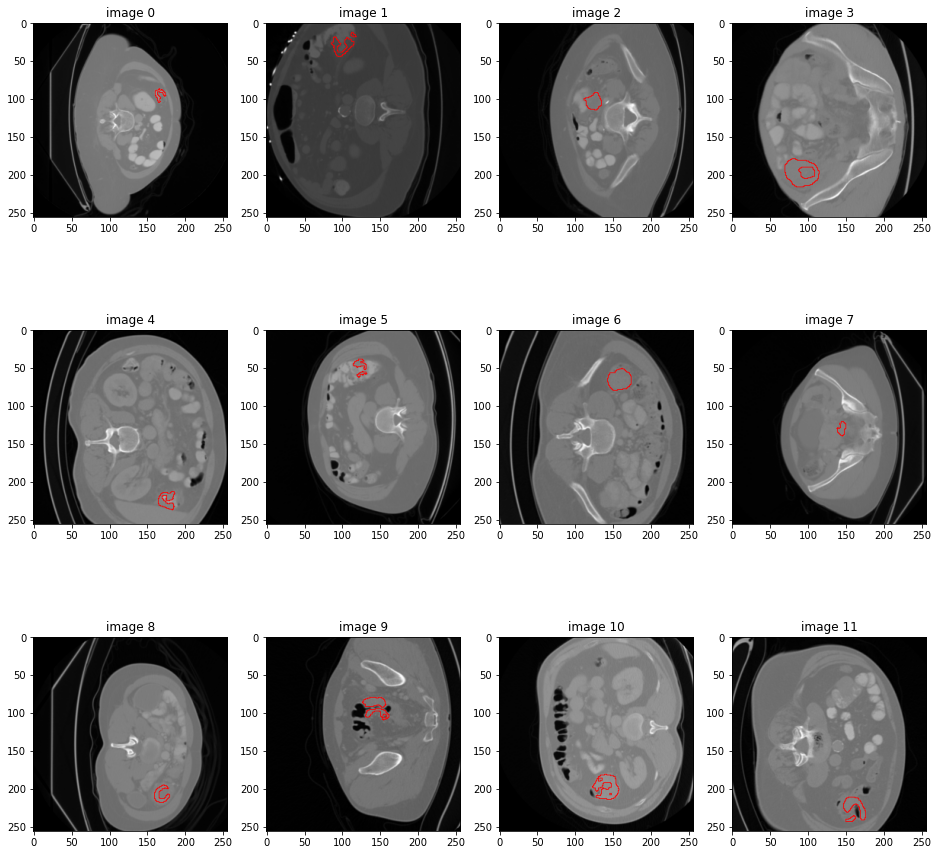

In [8]:
imgs, labels = next(iter(train_dataloader['train']))

def overlay_image(img, y_true):
    img = img.numpy()
    y_true = y_true.numpy()
    image = gray2rgb(img[0])
    image = outline(image, y_true[0], color=[255, 0, 0])
    plt.imshow(image)

columns = 4
rows = 3
fig=plt.figure(figsize=(16, 16))
for i, (img, label) in enumerate(zip(imgs, labels)):
    fig.add_subplot(rows, columns, i+1)
    plt.title('image ' + str(i))
    overlay_image(img, label)

## Model Architecture¶

In our project we compare two model architectures: the U-Net model and the combination of a ResNet-34 with the U-Net for the image segmentation task. In this demo, we show the *U-Net* model only. Both models are implemented in `architecture.py`.

In [9]:
import torch
from torchsummary import summary
from architecture import UNet

In [10]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0") # set device to GPU if available
model = UNet(n_channel=1, n_class=1).to(device)
summary(model, input_size=(1, args.image_size, args.image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14          [-1, 128,

## Loss function

To optimize our models in training we combine the *cross entropy loss* with the *dice loss*.

The cross entropy loss is from **pytorch** library. We implemented the dice coefficient in `loss.py`. The dice loss is calculated as *(1 - dice coefficient)*.

In [11]:
from loss import dice_coef, calc_loss, print_metrics

## Training

We use the *SGD (Stochastic gradient descent)* optimizer in training. As learning rate scheduler we used *ReduceLROnPlateau*. It allows to dynamically reduce the learning rate based on the validation loss. Both of them are from the **pytorch** library.

We further implemented an early wtopping technique is also implemented in `train.py`. *Early stopping* is a method that allows you to specify a maximum number of training epochs after which the training is stopped if the validation loss did not improve.

We define the `train_model()` function in `train.py`. This function takes the optimizer, scheduler, and other parameters as arguments and starts training. It saves the model which shows the lowest validation loss.

We use Tensorboard to visualize the metrics after finishing training. We also save the metrics as a JSON file to allow us compare the results of each model easily.


In [12]:
from train import train_model
from torch.optim import lr_scheduler, SGD
import json

In [13]:
class Args():
    model_path = "./save/models/"
    metric_path = "./save/metrics/"
    model = "unet"
    dataset_type = "only_tumor"
    lr = 0.001
    epochs = 1
    earlystop = 30
    sched_patience = 10
    image_size = 256
    
args = Args()

In [14]:
# set device
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0") # set device to GPU if available
# specify optimizer function
optimizer = SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=args.lr, momentum=0.9)
# initialise learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', threshold_mode='abs', min_lr=1e-8, factor=0.1, patience=args.sched_patience)
# intialize the model
model = UNet(n_channel=1, n_class=1).to(device)
# initialize dictionary to save train informations about the model, dataset, and metrics at the end.
info = {'train': {}}
info_train = info['train']
info_train['model'] = args.model
info_train['dataset'] = args.dataset_type
info_train['image_size'] = args.image_size
info_train['train set size'] = len(train)
info_train['val set size'] = len(valid)
# start train
model, metric_t, metric_v = train_model(model, optimizer, scheduler, device, args.epochs, train_dataloader, info_train, args)
# save info as a json file at "./save/metrics"
with open(f"{args.metric_path}best_metric_{args.model}_{args.dataset_type}_{args.epochs}.json", "w") as json_file:
    json.dump(info, json_file, indent=4)

Epoch 1/1
----------
LR 0.001
train: bce: 0.731263, dice_loss: 0.986129, loss: 1.717392
val: bce: 0.731343, dice_loss: 0.982582, loss: 1.713924
Validation loss decreased (inf --> 1.713924).  Saving best model ...
0m 37s
Best val loss: 1.713924


In [15]:
# to see visualizations of loss change
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.3.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


## Testing

We define `load_datasets()` and `load_dataloader()` functions in `test.py` to load the test set which was split into test and training set before. The information which image belongs to which subset is drawn from the JSON data index.

Similar to `train_model()` in training we defined `test_model()` in `test.py` which starts evaluating the model and prints the evaluation metrics at the end. The evaluation metrics are saved in the metrics JSON file. We created a `metrics_summary()` function in utils.py, which returns statistics on each model approach.

In our experiments the U-Net model based on an oversampled dataset yielded the best performance metrics. In this demo, we are going to load this model to demonstrate its predictions.

In [16]:
from test import load_datasets, load_dataloader, test_model

In [17]:
class Args():
    testimages = "./data/npy_images"
    testlabels = "./data/npy_labels"
    jsonfile = "./data/data_index_subsets.json"
    image_size = 256
    transform = True
    model_path = "./save/models/"
    metric_path = "./save/metrics/"
    model = "unet"
    test_dataset_type = "oversample"
    epochs = 200
    pred_save = True
    
args = Args()

In [18]:
# initialize device and model
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0") # set device to GPU if available
model = UNet(n_channel=1, n_class=1).to(device)

# load test data
test = load_datasets(args)
test_dataloader = load_dataloader(test)

# initialize a dictionary to save metrics for evaluation
info_test = {'test set size':0, 'average_dice_score':0, \
             'number of cancer case': 0, 'average_cancer_dice_score':0, \
             'number of non-cancer case': 0, 'average_non_cancer_dice_score':0, \
             'gt_c_pd_c_overlap':0, 'gt_c_pd_c_no_overlap':0, 'gt_c_pd_no_c':0, \
             'gt_n_pd_n': 0, 'gt_n_pd_c':0, 'dice_score_each_slice':[]}
info_test['test set size'] = len(test_dataloader['test'])

# start test
result = test_model(model, device, test_dataloader, args.pred_save, info_test, args)

# save the result from the evalutaion
with open(f"{args.metric_path}best_metric_{args.model}_{args.test_dataset_type}_{args.epochs}.json", 'ab+') as f:
    f.seek(0,2)                                #Go to the end of file    
    if f.tell() == 0 :                         #Check if file is empty
        f.write(json.dumps(info_test, indent=4).encode())  #If empty, write an array
    else:  
        f.seek(-1,2)           
        f.truncate() 
        f.write(', "test": '.encode()) 
        f.write(json.dumps(info_test, indent=4).encode())    #Dump the dictionary
        f.write('}'.encode())  

----------
The Evaluation Starts ...
----------
The total samples: 1348
The average dice score is 0.9625943899154663.
The number of cancer samples: 127
The average dice score of the slices which have cancer is 0.7099751234054565.
The number of correct cases when the prediction predicts some poriton of the cancer: 109
The number of incorrect cases when the prediction predicts some poriton of the cancer: 0
The number of cases when the prediction predicts no cancer but it has cancer: 18
The number of non-cancer samples: 1221
The average dice score of the slices which have non-cancer is 0.9888702034950256.
The number of cases when the prediction predicts no cancer when it has no cancer: 1207
The number of cases when the prediction predicts cancer when it has no cancer: 14
0m 29s


## Visualizing predictions from the trained model

We define `overlay_plot()` at `utils.py` to overlay three images (CT image, ground truth label and predicted label). The red line shows the ground truth label and the green line shows the predicted label from the trained model. 

At **Testing**, we received the result from the `test_model()` function. The CT image, ground truth label, and predicted labe are saved at this result. We will show the visualizations of the overlay images using this result. 

In [19]:
import matplotlib.pyplot as plt
from utils import gray2rgb, outline, overlay_plot
import random
import numpy as np

In [20]:
class Args():
    plot_path = "./save/plots"

args = Args()
os.makedirs(args.plot_path, exist_ok=True)

In [21]:
c_index = list()
n_index = list()
for i, j in result.items():
    if j['cancer_gt'] and j['cancer_pd']:
        c_index.append(i)
    else:
        n_index.append(i)

In [22]:
cancer = random.sample(c_index, 6)
no_cancer = random.sample(n_index, 6)
rand_index = np.concatenate((cancer, no_cancer))

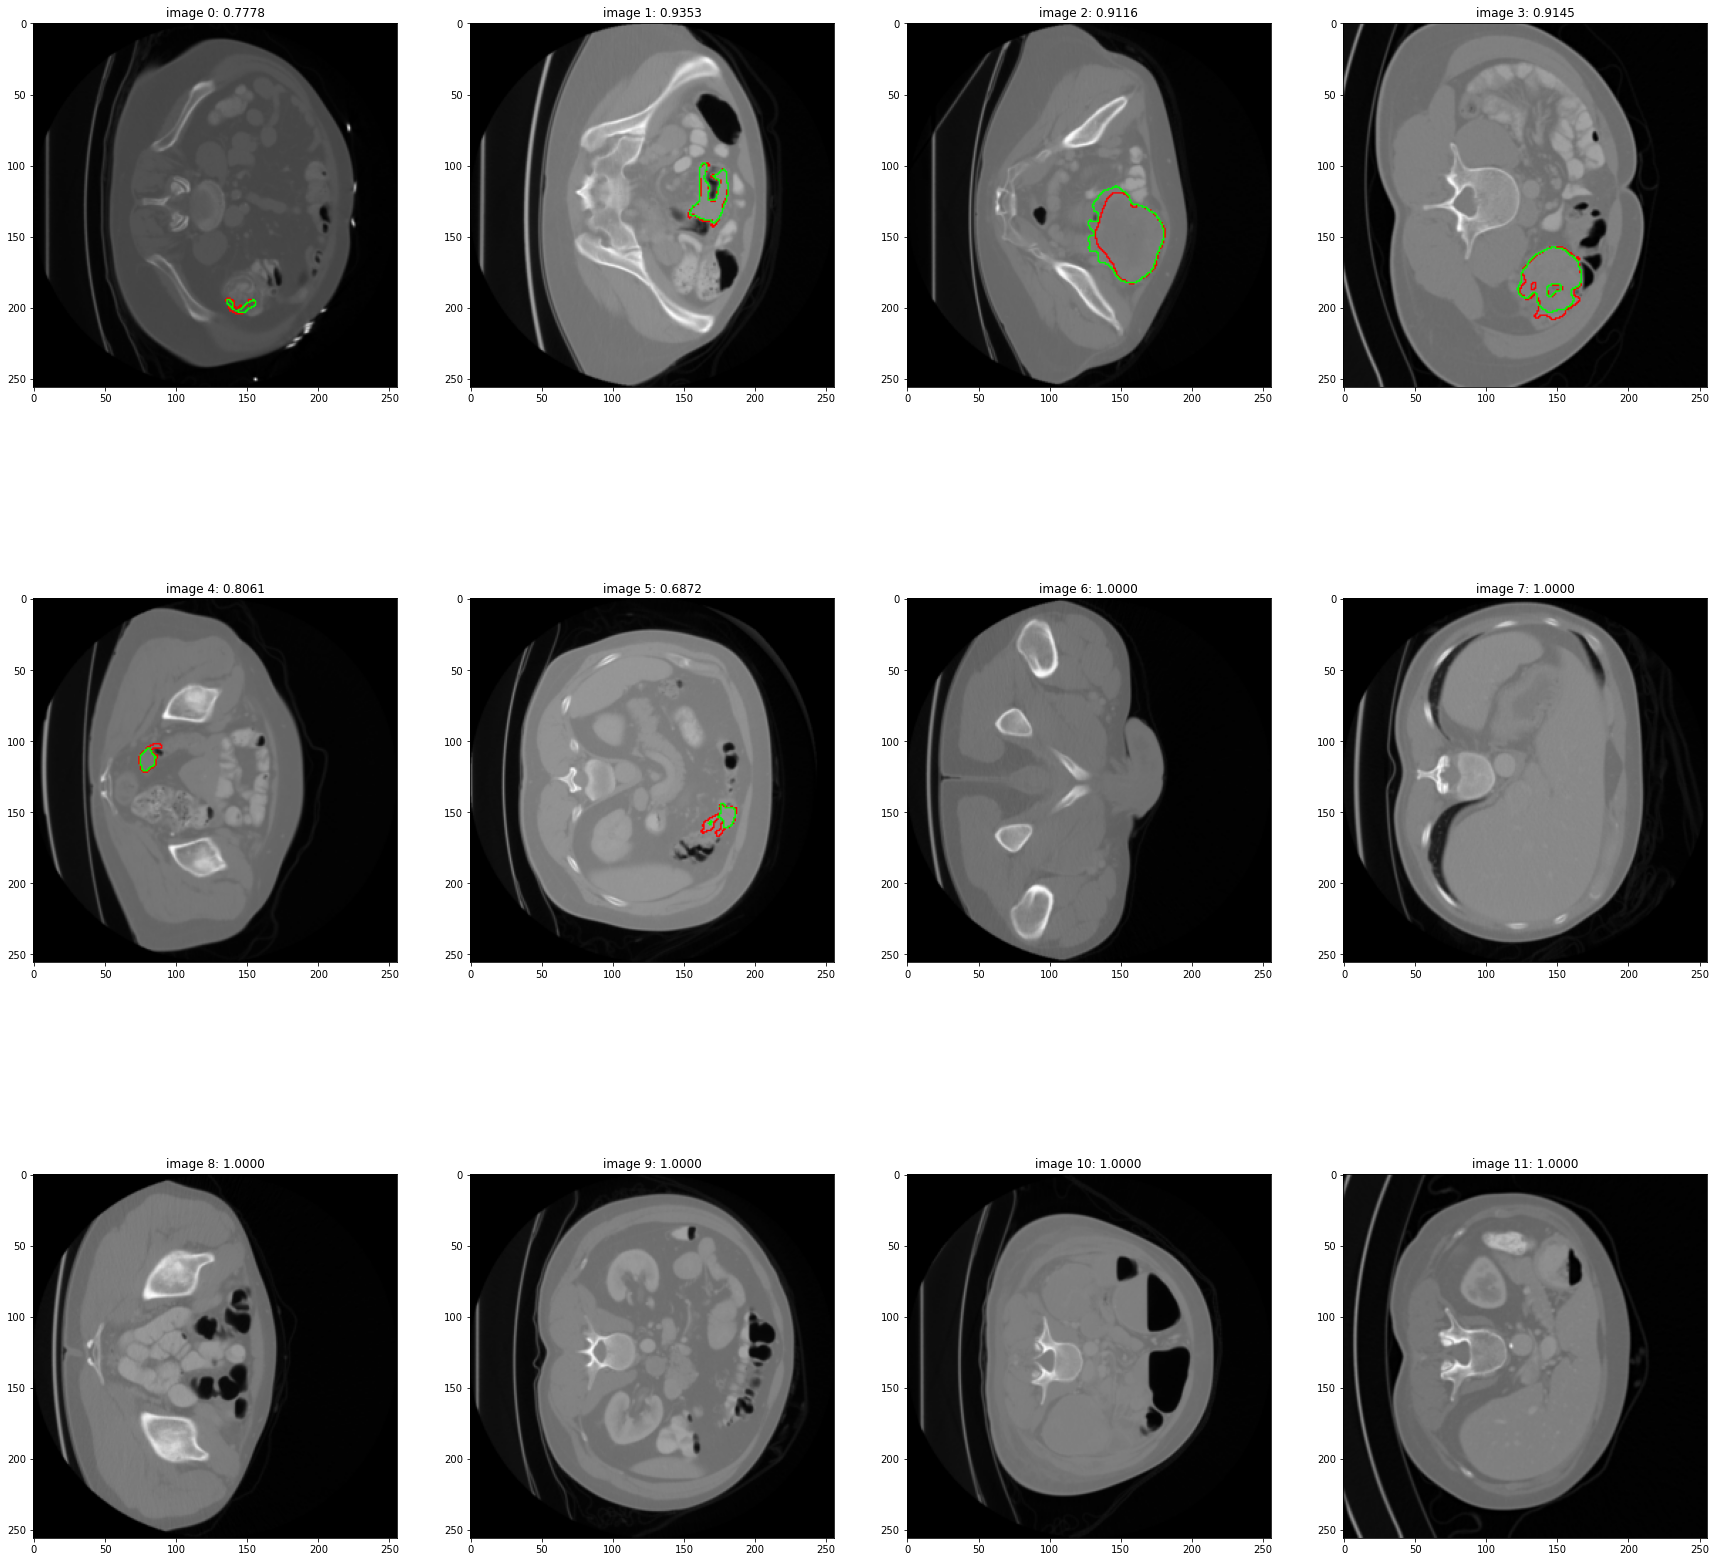

In [23]:
columns = 4
rows = 3
fig=plt.figure(figsize=(30, 30))
for pos, i in enumerate(rand_index):
    fig.add_subplot(rows, columns, pos+1)
    plt.title('image {}: {:.4f}'.format(pos, result[i]['dice']))
    image = overlay_plot(result[i]['img'], result[i]['label'], result[i]['pred'], i, args, False)
    plt.imshow(image)